![image.png](attachment:image.png)

# Info

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

# Libraries Import

In [13]:
import glob
import cv2
import tqdm

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [14]:
import kagglehub

In [15]:
import os
from collections import Counter
import random
import re
import json
import pickle
from collections import Counter
import math

In [16]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import backend as K

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score


In [18]:
from concurrent.futures import ThreadPoolExecutor

# Constants

In [19]:
IMG_W = 28
IMG_H = 28

EPOCHS = 50
BATCH_SIZE = 256

VAL_SPLIT = 0.2
TEST_SPLIT = 0.2

# BASE_DIR = r'drive/MyDrive/mnist_proj'
BASE_DIR = ''

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Functions

In [20]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# Dataset Download

In [21]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("oddrationale/mnist-in-csv")

print("Path to dataset files:", dataset_path)

100%|██████████| 15.2M/15.2M [00:05<00:00, 2.91MB/s]

Extracting files...


Path to dataset files: C:\Users\yosef\.cache\kagglehub\datasets\oddrationale\mnist-in-csv\versions\2


# Dataset Read

In [22]:
os.listdir(dataset_path)

['mnist_test.csv', 'mnist_train.csv']

In [23]:
train_df_path = os.path.join(dataset_path, 'mnist_train.csv')
test_df_path = os.path.join(dataset_path, 'mnist_test.csv')

In [24]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

In [25]:
print(f"Total images: {len(train_df)}")
print(f"Total labels: {len(test_df)}")

Total images: 60000
Total labels: 10000


In [26]:
train_df.describe(include='all')

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
count,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,4.453933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,2.889270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


In [27]:
test_df.describe(include='all')

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
count,10000.000000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.000000,10000.000000,10000.000000,10000.0000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,4.443400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.179300,0.163600,0.052600,0.0006,0.0,0.0,0.0,0.0,0.0,0.0
std,2.895865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.674149,5.736072,2.420004,0.0600,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,253.000000,156.000000,6.0000,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
test_df.iloc[0].unique()

array([  7,   0,  84, 185, 159, 151,  60,  36, 222, 254, 241, 198, 170,
        52,  67, 114,  72, 163, 227, 225, 250, 229, 140,  17,  66,  14,
        59,  21, 236, 106,  83, 253, 209,  18,  22, 233, 255, 129, 238,
        44, 249,  62, 133, 187,   5,   9, 205, 248,  58, 126, 182,  75,
       251, 240,  57,  19, 221, 166,   3, 203, 219,  35,  38,  77,  31,
       224, 115,   1,  61, 242, 121,  40, 207])

In [29]:
data_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [30]:
# data_df = data_df.iloc[0:10_000,:]

In [31]:
images = []
labels = []

for i in tqdm.tqdm(range(len(data_df))):
    label = data_df.iloc[i, 0]
    img = data_df.iloc[i, 1:].values.reshape(28, 28,1).astype(float)
    images.append(img)
    labels.append(label)

100%|██████████| 70000/70000 [00:10<00:00, 6573.99it/s]


In [32]:
fashion_mnist_labels = {
    0: "Zero",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eight",
    9: "Nine"
}

# Exploration & Visualization

In [33]:
print(f"Total images: {len(images)}")
print(f"Total labels: {len(labels)}")

Total images: 70000
Total labels: 70000


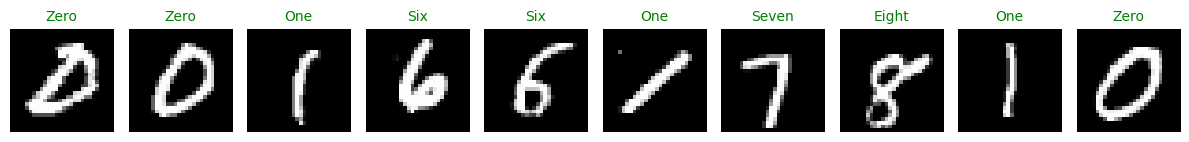

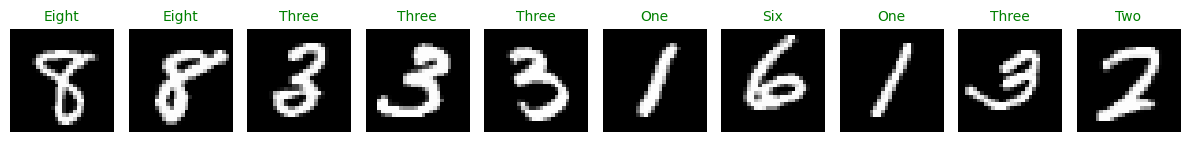

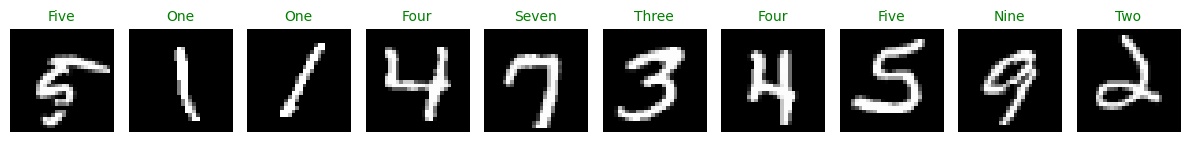

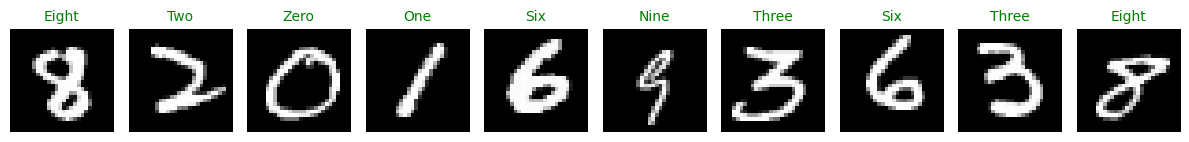

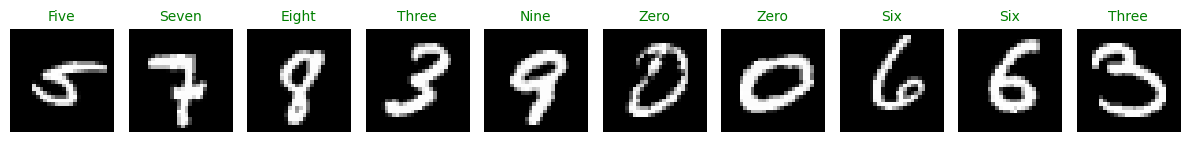

In [34]:
N_ROWS = 5
N_COLS = 10

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, N_COLS, figsize=(12, 8))

    for j in range(N_COLS):
            id_j = np.random.randint(0, len(images))
            label_i = fashion_mnist_labels[labels[id_j]]
            img_i = images[id_j]

            axs[j].imshow(img_i, cmap='gray')
            axs[j].set_title(f"{label_i}", fontsize=10, color='green')
            axs[j].axis('off')

    fig.tight_layout()
    plt.show()

In [35]:
label_counts = Counter(labels)
key_val_counter = dict([ (fashion_mnist_labels[key], val) for key, val in label_counts.items() ])

for key, val in key_val_counter.items():
    print(f"{key:>15}: {val}")

           Five: 6313
           Zero: 6903
           Four: 6824
            One: 7877
           Nine: 6958
            Two: 6990
          Three: 7141
            Six: 6876
          Seven: 7293
          Eight: 6825


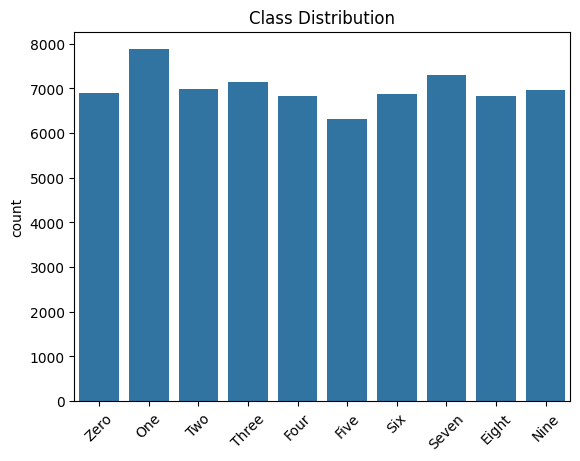

In [36]:
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xticks(ticks=np.arange(10), labels=[fashion_mnist_labels[i] for i in range(10)], rotation=45)
plt.show()

# Labels Preprocessing

In [37]:
def process_label(label):
    label = str(label).lower().strip()
    return label

In [38]:
labels_processed = [process_label(label) for label in tqdm.tqdm(labels, desc="Processing labels")]

Processing labels: 100%|██████████| 70000/70000 [00:00<00:00, 1453961.14it/s]


In [39]:
label_encoder = LabelEncoder()
label_encoder.fit(labels_processed)

LabelEncoder()

In [40]:
N_CLASSES = len(label_encoder.classes_)
print(f"Classes ({N_CLASSES}):", label_encoder.classes_)

Classes (10): ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [41]:
y = label_encoder.transform(labels_processed)
y = np.array(y)

In [42]:
print(f"{y.shape = }")

y.shape = (70000,)


# Images Preprocessing

Blur Filters

In [43]:
# # make image smooth
# def apply_filter_gaussian(image, kernel_size=(5, 5), sigma=0):
#     return cv2.GaussianBlur(image, kernel_size, sigma).astype(image.dtype)

# # remove salt and pepper noise
# def apply_filter_median(image, kernel_size=5):
#     return cv2.medianBlur(image, kernel_size).astype(image.dtype)

# # preserve edges while reducing noise
# def apply_filter_bilateral(image, d=9, sigma_color=75, sigma_space=75):
#     return cv2.bilateralFilter(image, d, sigma_color, sigma_space).astype(image.dtype)

Edge Detection

In [44]:
# def apply_laplacian(image, ksize=3):
#     return cv2.Laplacian(image, cv2.CV_32F, ksize=ksize).astype(image.dtype)

# def apply_sobel(image, dx=1, dy=0, ksize=3):
#     return cv2.Sobel(image, cv2.CV_32F, dx, dy, ksize=ksize).astype(image.dtype)

# def apply_canny(image, threshold1=50, threshold2=60):
#     return cv2.Canny(image, threshold1, threshold2).astype(image.dtype)

Kmeans

In [45]:
# def apply_kmeans(image, n_colors=12):
#     n_channels = image.shape[2] if len(image.shape) == 3 else 1

#     Z = image.reshape((-1, n_channels)).astype(np.float32)

#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#     _, label, center = cv2.kmeans(Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

#     center = np.uint8(center)
#     res = center[label.flatten()]
#     clustered = res.reshape(image.shape)
#     return clustered

In [46]:
def preprocess_image(image):
    # Resize the image to the target dimensions
    image = cv2.resize(image, (IMG_W, IMG_H))

    # Ensure the image has channel dimension
    if len(image.shape) == 2:
        image = np.reshape(image, (IMG_W, IMG_H, 1))

    # image = apply_filter_median(image)

    # append new channel for kmean
    # image = np.stack((image, apply_sobel(image), apply_canny(image)), axis=-1)

    image = (image / 255.0).astype(np.float32)

    image = np.clip(image, 0.0, 1.0)

    return image.astype(np.float32)

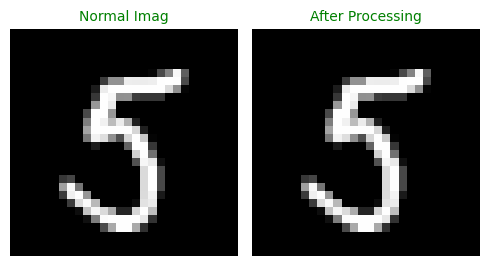

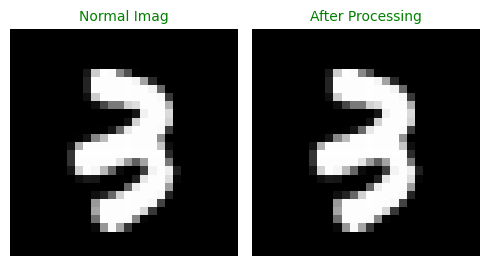

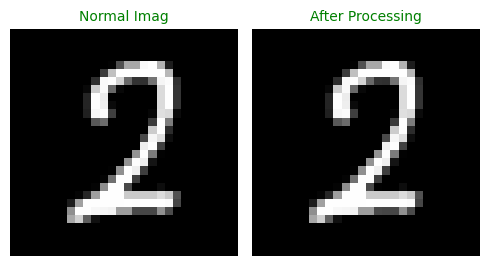

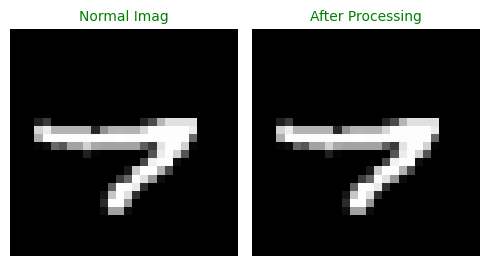

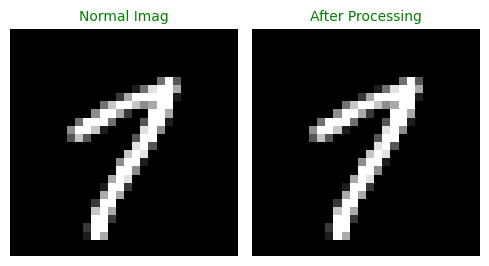

In [47]:
N_ROWS = 5
IMG_SHAPE = None

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, 2, figsize=(5, 5))

    id_j = np.random.randint(0, len(images))
    label_i = labels[id_j]

    img_i = images[id_j]

    img_i_processed = preprocess_image(img_i)

    axs[0].imshow(img_i.squeeze(), cmap='gray')
    axs[0].set_title(f"Normal Imag", fontsize=10, color='green')
    axs[0].axis('off')

    axs[1].imshow(img_i_processed, cmap='gray')
    axs[1].set_title(f"After Processing", fontsize=10, color='green')
    axs[1].axis('off')

    IMG_SHAPE = img_i_processed.shape

    fig.tight_layout()
    plt.show()

# Data Split

In [48]:
idx = np.array(list(range(len(images))))

# First split: Train vs (Val+Test)
idx_train, idx_val = train_test_split(
    idx,
    test_size=VAL_SPLIT + TEST_SPLIT,
    random_state=RANDOM_STATE
)

# Second split: Val vs Test
idx_val, idx_test = train_test_split(
    idx_val,
    test_size=TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT),
    random_state=RANDOM_STATE
)


# Later when you need the actual data:
X_train = np.array([images[i] for i in idx_train])
X_val   = np.array([images[i] for i in idx_val])
X_test   = np.array([images[i] for i in idx_test])

y_train = np.array([labels[i] for i in idx_train])
y_val   = np.array([labels[i] for i in idx_val])
y_test   = np.array([labels[i] for i in idx_test])

print(f"{X_train.shape = }")
print(f"{X_val.shape = }")
print(f"{X_test.shape = }")

print(f"{y_train.shape = }")
print(f"{y_val.shape = }")
print(f"{y_test.shape = }")

X_train.shape = (42000, 28, 28, 1)
X_val.shape = (14000, 28, 28, 1)
X_test.shape = (14000, 28, 28, 1)
y_train.shape = (42000,)
y_val.shape = (14000,)
y_test.shape = (14000,)


# Data Augmentation

In [49]:
def custom_augmentation_numpy(image):
    # -----------------------------
    # 1. Random Horizontal Flip
    # if np.random.rand() > 0.5:
    #     image = np.fliplr(image)

    # # -----------------------------
    # # 2. Random Vertical Flip
    # if np.random.rand() > 0.5:
    #     image = np.flipud(image)

    # -----------------------------
    # 3. Random Rotation
    # if np.random.rand() > 0.5:
    #     angle = np.random.uniform(-5, 5)
    #     h, w = image.shape[:2]
    #     center = (w // 2, h // 2)
    #     M = cv2.getRotationMatrix2D(center, angle, 1.0)
    #     image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    # -----------------------------
    # 4. Random Crop and Resize Back
    # if np.random.rand() > 0.5:
    #     h, w = image.shape[:2]
    #     crop_scale = np.random.uniform(0.95, 1.0)
    #     new_h, new_w = int(h * crop_scale), int(w * crop_scale)
    #     top = np.random.randint(0, h - new_h + 1)
    #     left = np.random.randint(0, w - new_w + 1)
    #     image = image[top:top + new_h, left:left + new_w]
    #     image = cv2.resize(image, (w, h))

    # -----------------------------
    # 5. Random Brightness
    # if np.random.rand() > 0.5:
    #     brightness_shift = np.random.uniform(-0.05, 0.05)
    #     image = image + brightness_shift
    #     image = np.clip(image, 0, 1)

    # -----------------------------
    # 6. Random Contrast
    # if np.random.rand() > 0.5:
    #     factor = np.random.uniform(0.95, 1.05)
    #     mean = image.mean(axis=(0, 1), keepdims=True)
    #     image = (image - mean) * factor + mean
    #     image = np.clip(image, 0, 1)

    # -----------------------------
    # 7. Random Gaussian Noise
    # if np.random.rand() > 0.5:
    #     noise = np.random.normal(0, 0.05, image.shape)
    #     image = image + noise
    #     image = np.clip(image, 0, 1)

    # if len(image.shape) == 2:
    #     image = np.reshape(image, (image.shape[0], image.shape[1], 1))

    return image

## Siamese

In [50]:
class MyDataGeneratorSiamesePair(Sequence):
    def __init__(self, images, labels, batch_size, feature_extractor_model=None, augment=True, shuffle=True, n_workers=4):
        self.images = np.array(images)
        self.labels = np.array(labels)

        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers

        # store feature extractor model
        self.feature_extractor_model = feature_extractor_model
        self.features_space = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        # load batch pairs
        batch_pair_inputs_1, batch_pair_inputs_2, batch_pair_labels = self._load_images_parallel(
            self.images, self.labels, self.batch_size
        )

        if self.augment:
            batch_pair_inputs_1 = np.stack([custom_augmentation_numpy(img) for img in batch_pair_inputs_1], axis=0)
            batch_pair_inputs_2 = np.stack([custom_augmentation_numpy(img) for img in batch_pair_inputs_2], axis=0)

        return (batch_pair_inputs_1, batch_pair_inputs_2), np.array(batch_pair_labels)

    def on_epoch_end(self):
        """Shuffle indices and refresh embeddings if feature extractor exists."""
        self.indices = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indices)

        if self.feature_extractor_model is not None:
            self.features_space = self.feature_extractor_model.predict(self.images, verbose=0)

    def set_feature_extractor(self, feature_extractor_model):
        """Attach/change the feature extractor model externally."""
        self.feature_extractor_model = feature_extractor_model
        if feature_extractor_model is None:
            self.features_space = None
        else:
            self.features_space = feature_extractor_model.predict(self.images, verbose=0)

    def _load_images_parallel(self, batch_images, batch_labels, batch_size):
        batch_pair_inputs_1, batch_pair_inputs_2, batch_pair_labels = [], [], []

        for _ in range(batch_size):
            idx1 = np.random.randint(0, len(batch_images))
            img1 = preprocess_image(batch_images[idx1])
            label1 = batch_labels[idx1]

            if np.random.rand() > 0.5:
                # Positive pair
                idx2_candidates = np.where(batch_labels == label1)[0]
                idx2 = np.random.choice(idx2_candidates)
                label = 1
            else:
                # Negative pair with feature-space sampling
                idx2_candidates = np.where(batch_labels != label1)[0]

                if self.features_space is not None:
                    neg_space_representation = self.features_space[idx2_candidates]
                    pos_space_representation = self.features_space[idx1]

                    distances = np.linalg.norm(pos_space_representation - neg_space_representation, axis=1)
                    prob = np.exp(-distances) / np.sum(np.exp(-distances))
                    idx2 = np.random.choice(idx2_candidates, p=prob)
                else:
                    idx2 = np.random.choice(idx2_candidates)

                label = 0

            img2 = preprocess_image(batch_images[idx2])

            batch_pair_inputs_1.append(img1)
            batch_pair_inputs_2.append(img2)
            batch_pair_labels.append(label)

        return np.array(batch_pair_inputs_1), np.array(batch_pair_inputs_2), np.array(batch_pair_labels)


In [51]:
train_siamese_generator = MyDataGeneratorSiamesePair(X_train, y_train,
                                       batch_size=BATCH_SIZE,
                                       augment=True,
                                       shuffle=True)

train_siamese_pure_generator = MyDataGeneratorSiamesePair(X_train, y_train,
                                            batch_size=BATCH_SIZE,
                                            augment=False,
                                            shuffle=False)

val_siamese_generator = MyDataGeneratorSiamesePair(X_val, y_val,
                                     batch_size=BATCH_SIZE,
                                     augment=False,
                                     shuffle=False)

test_siamese_generator = MyDataGeneratorSiamesePair(X_test, y_test,
                                      batch_size=BATCH_SIZE,
                                      augment=False,
                                      shuffle=False)

Count Similar:    131
Count Dissimilar: 125


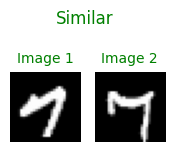

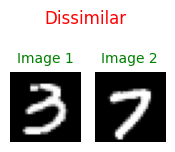

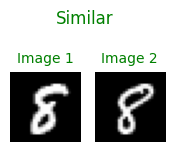

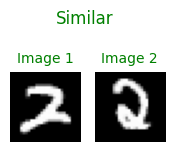

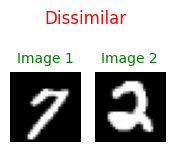

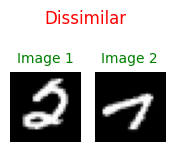

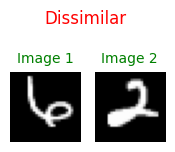

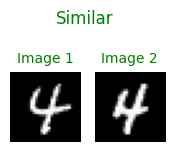

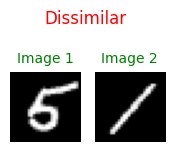

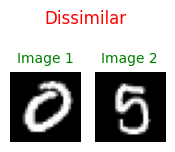

In [52]:
N_ROWS = 10

batch_i = train_siamese_generator[np.random.randint(0, len(train_siamese_generator) - 1)]
(batch_pair_inputs_1, batch_pair_inputs_2), batch_pair_labels = batch_i

i_counter = 0

print(f"Count Similar:    {np.sum(batch_pair_labels == 1)}")
print(f"Count Dissimilar: {np.sum(batch_pair_labels == 0)}")


for i in range(N_ROWS):
    if i_counter >= BATCH_SIZE:
        break

    plt.figure(figsize=(2, 2))

    plt.subplot(1, 2, 1)
    plt.imshow(batch_pair_inputs_1[i_counter].squeeze(), cmap='gray')
    plt.title(f"Image 1", fontsize=10, color='green')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(batch_pair_inputs_2[i_counter].squeeze(), cmap='gray')
    plt.title(f"Image 2", fontsize=10, color='green')
    plt.axis('off')

    plt.suptitle(f"{'Similar' if batch_pair_labels[i_counter] == 1 else 'Dissimilar'}", fontsize=12, color=['Red', 'Green'][batch_pair_labels[i_counter]])
    plt.show()
    i_counter += 1

## Triplet

In [53]:
class MyDataGeneratorTriplet(Sequence):
    def __init__(self, images, labels, batch_size, feature_extractor_model=None, augment=True, shuffle=True, n_workers=4):
        self.images = np.array(images)
        self.labels = np.array(labels)

        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers

        # Store feature extractor model
        self.feature_extractor_model = feature_extractor_model
        self.features_space = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        # Generate triplets
        batch_a, batch_p, batch_n, batch_labels = self._load_images_parallel(
            self.images, self.labels, self.batch_size
        )

        if self.augment:
            batch_a = np.stack([custom_augmentation_numpy(img) for img in batch_a], axis=0)
            batch_p = np.stack([custom_augmentation_numpy(img) for img in batch_p], axis=0)
            batch_n = np.stack([custom_augmentation_numpy(img) for img in batch_n], axis=0)

        return (batch_a, batch_p, batch_n), batch_labels

    def on_epoch_end(self):
        """Shuffle and refresh embeddings once per epoch."""
        self.indices = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indices)

        if self.feature_extractor_model is not None:
            self.features_space = self.feature_extractor_model.predict(self.images, verbose=0)

    def set_feature_extractor(self, feature_extractor_model):
        """Attach/change the feature extractor model externally."""
        self.feature_extractor_model = feature_extractor_model
        if feature_extractor_model is None:
            self.features_space = None
        else:
            self.features_space = feature_extractor_model.predict(self.images, verbose=0)

    def _load_images_parallel(self, batch_images, batch_labels, batch_size):
        batch_a, batch_p, batch_n, batch_labels_out = [], [], [], []

        for _ in range(batch_size):
            anchor_class, negative_class = np.random.choice(np.unique(batch_labels), 2, replace=False)

            anchor_idx = np.random.choice(np.where(batch_labels == anchor_class)[0])

            # Negative candidates
            all_n_candidates = np.where(batch_labels != anchor_class)[0]

            if self.features_space is not None:
                neg_space_representation = self.features_space[all_n_candidates]
                anchor_space_representation = self.features_space[anchor_idx]

                distance = np.linalg.norm(anchor_space_representation - neg_space_representation, axis=1)
                prob = np.exp(-distance) / np.sum(np.exp(-distance))

                negative_idx = np.random.choice(all_n_candidates, p=prob)
            else:
                negative_idx = np.random.choice(all_n_candidates)

            a_img = preprocess_image(batch_images[anchor_idx])
            p_img = preprocess_image(random.choice(batch_images[batch_labels == anchor_class]))
            n_img = preprocess_image(batch_images[negative_idx])

            label_dummy = 0  # Triplet loss doesn’t need labels

            batch_a.append(a_img)
            batch_p.append(p_img)
            batch_n.append(n_img)
            batch_labels_out.append(label_dummy)

        return (
            np.array(batch_a),
            np.array(batch_p),
            np.array(batch_n),
            np.array(batch_labels_out),
        )


In [54]:
train_triplet_generator = MyDataGeneratorTriplet(X_train, y_train,
                                       batch_size=BATCH_SIZE,
                                       augment=True,
                                       shuffle=True)

train_triplet_pure_generator = MyDataGeneratorTriplet(X_train, y_train,
                                            batch_size=BATCH_SIZE,
                                            augment=False,
                                            shuffle=False)

val_triplet_generator = MyDataGeneratorTriplet(X_val, y_val,
                                     batch_size=BATCH_SIZE,
                                     augment=False,
                                     shuffle=False)

test_triplet_generator = MyDataGeneratorTriplet(X_test, y_test,
                                      batch_size=BATCH_SIZE,
                                      augment=False,
                                      shuffle=False)

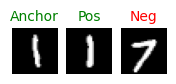

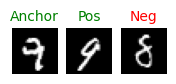

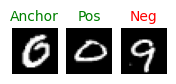

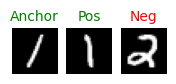

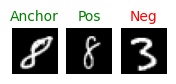

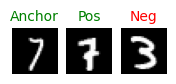

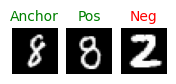

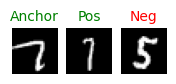

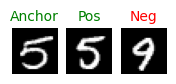

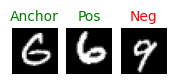

In [55]:
N_ROWS = 10

batch_i = train_triplet_generator[np.random.randint(0, len(train_triplet_generator) - 1)]
(batch_pair_inputs_a, batch_pair_inputs_p, batch_pair_inputs_n), batch_labels = batch_i

i_counter = 0


for i in range(N_ROWS):
    if i_counter >= BATCH_SIZE:
        break

    plt.figure(figsize=(2, 2))

    plt.subplot(1, 3, 1)
    plt.imshow(batch_pair_inputs_a[i_counter].squeeze(), cmap='gray')
    plt.title(f"Anchor", fontsize=10, color='green')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(batch_pair_inputs_p[i_counter].squeeze(), cmap='gray')
    plt.title(f"Pos", fontsize=10, color='green')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(batch_pair_inputs_n[i_counter].squeeze(), cmap='gray')
    plt.title(f"Neg", fontsize=10, color='red')
    plt.axis('off')

    plt.show()

    i_counter += 1

## Triplet with CLS head

In [56]:
class MyDataGeneratorTripletCLS(Sequence):
    def __init__(self, images, labels, batch_size, feature_extractor_model=None, augment=True, shuffle=True, n_workers=4):
        self.images = np.array(images)
        self.labels = np.array(labels)

        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers

        # Store feature extractor model
        self.feature_extractor_model = feature_extractor_model
        self.features_space = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        # Generate triplets
        batch_a, batch_p, batch_n, batch_labels, anchor_label = self._load_images_parallel(
            self.images, self.labels, self.batch_size
        )

        if self.augment:
            batch_a = np.stack([custom_augmentation_numpy(img) for img in batch_a], axis=0)
            batch_p = np.stack([custom_augmentation_numpy(img) for img in batch_p], axis=0)
            batch_n = np.stack([custom_augmentation_numpy(img) for img in batch_n], axis=0)

        return (batch_a, batch_p, batch_n,), (batch_labels, anchor_label)

    def on_epoch_end(self):
        """Shuffle and refresh embeddings once per epoch."""
        self.indices = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indices)

        if self.feature_extractor_model is not None:
            self.features_space = self.feature_extractor_model.predict(self.images, verbose=0)

    def set_feature_extractor(self, feature_extractor_model):
        """Attach/change the feature extractor model externally."""
        self.feature_extractor_model = feature_extractor_model
        if feature_extractor_model is None:
            self.features_space = None
        else:
            self.features_space = feature_extractor_model.predict(self.images, verbose=0)

    def _load_images_parallel(self, batch_images, batch_labels, batch_size):
        batch_a, batch_p, batch_n, batch_labels_out = [], [], [], []
        anchor_label = []

        for _ in range(batch_size):
            anchor_class, negative_class = np.random.choice(np.unique(batch_labels), 2, replace=False)

            anchor_idx = np.random.choice(np.where(batch_labels == anchor_class)[0])

            # Negative candidates
            all_n_candidates = np.where(batch_labels != anchor_class)[0]

            if self.features_space is not None:
                neg_space_representation = self.features_space[all_n_candidates]
                anchor_space_representation = self.features_space[anchor_idx]

                distance = np.linalg.norm(anchor_space_representation - neg_space_representation, axis=1)
                prob = np.exp(-distance) / np.sum(np.exp(-distance))

                negative_idx = np.random.choice(all_n_candidates, p=prob)
            else:
                negative_idx = np.random.choice(all_n_candidates)

            a_img = preprocess_image(batch_images[anchor_idx])
            p_img = preprocess_image(random.choice(batch_images[batch_labels == anchor_class]))
            n_img = preprocess_image(batch_images[negative_idx])

            label_dummy = 0  # Triplet loss doesn’t need labels

            batch_a.append(a_img)
            batch_p.append(p_img)
            batch_n.append(n_img)
            batch_labels_out.append(label_dummy)
            anchor_label.append(anchor_class)

        return (
            np.array(batch_a),
            np.array(batch_p),
            np.array(batch_n),
            np.array(batch_labels_out),
            np.array(anchor_label)
        )


In [57]:
train_triplet_cls_generator = MyDataGeneratorTripletCLS(X_train, y_train,
                                       batch_size=BATCH_SIZE,
                                       augment=True,
                                       shuffle=True)

train_triplet_cls_pure_generator = MyDataGeneratorTripletCLS(X_train, y_train,
                                            batch_size=BATCH_SIZE,
                                            augment=False,
                                            shuffle=False)

val_triplet_cls_generator = MyDataGeneratorTripletCLS(X_val, y_val,
                                     batch_size=BATCH_SIZE,
                                     augment=False,
                                     shuffle=False)

test_triplet_cls_generator = MyDataGeneratorTripletCLS(X_test, y_test,
                                      batch_size=BATCH_SIZE,
                                      augment=False,
                                      shuffle=False)

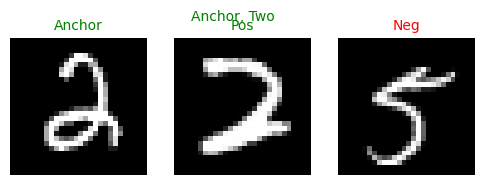

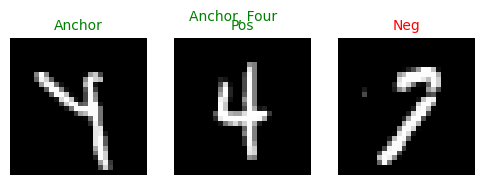

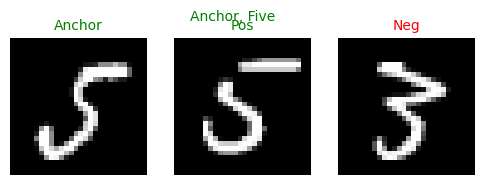

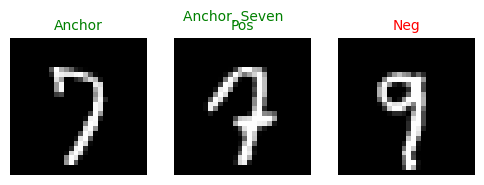

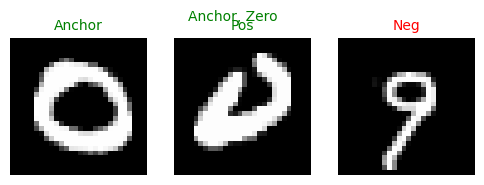

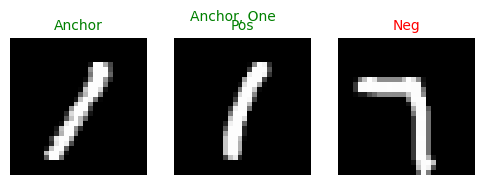

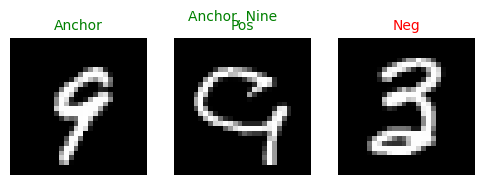

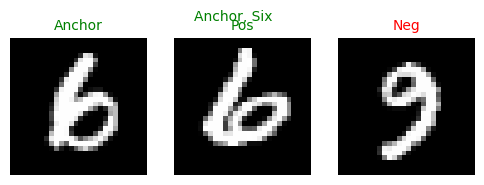

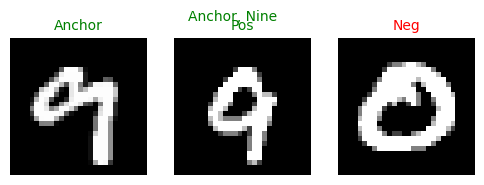

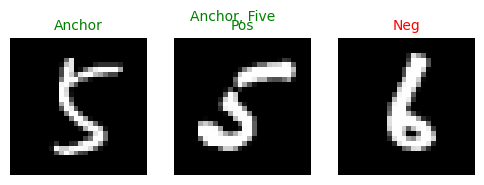

In [58]:
N_ROWS = 10

batch_i = train_triplet_cls_generator[np.random.randint(0, len(train_triplet_generator) - 1)]
(batch_pair_inputs_a, batch_pair_inputs_p, batch_pair_inputs_n), (batch_labels, anchor_label) = batch_i

i_counter = 0


for i in range(N_ROWS):
    if i_counter >= BATCH_SIZE:
        break

    plt.figure(figsize=(6, 2))

    plt.suptitle(f"Anchor, {fashion_mnist_labels[anchor_label[i_counter]]} ", fontsize=10, color='green')

    plt.subplot(1, 3, 1)
    plt.imshow(batch_pair_inputs_a[i_counter].squeeze(), cmap='gray')
    plt.title(f"Anchor", fontsize=10, color='green')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(batch_pair_inputs_p[i_counter].squeeze(), cmap='gray')
    plt.title(f"Pos", fontsize=10, color='green')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(batch_pair_inputs_n[i_counter].squeeze(), cmap='gray')
    plt.title(f"Neg", fontsize=10, color='red')
    plt.axis('off')

    plt.show()

    i_counter += 1

# Model Encapsulation

In [59]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR, 'models_cache')
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [60]:
class HistoryCheckpoint(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.filepath = os.path.join(CACHE_MODELS_DIR_NAME, f'{model_name}.history.json')
        self.history = {}

        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                self.history = json.load(f)
                print(F'Model {self.model_name} history loaded from cache')
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))

        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)

    def get_history(self):
        return self.history

In [61]:
class CustomModel:
    def __init__(self, name, training_model, feature_extractor_model, train_type, data_gens):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()

        self.training_model = training_model
        self.feature_extractor_model = feature_extractor_model
        self.data_gens = data_gens

        self.train_type = train_type

        self._history = {}
        self.load()

    def fit(self, data_gen, validation_data, epochs, batch_size=None, force_train=False,):

        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'

        es = EarlyStopping(monitor='val_loss', patience=11, verbose=1, restore_best_weights=True)
        mcp = ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only=True,
                              save_weights_only=True, mode='min', verbose=1)
        rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
        hcp = HistoryCheckpoint(self.name)

        if self.trained == False or force_train:

            # data_gen.set_feature_extractor(self.feature_extractor_model)

            self.training_model.fit(
                data_gen,
                validation_data=validation_data,
                callbacks=[es, mcp, rop, hcp],
                epochs=epochs,
                batch_size=batch_size
            )

            self.trained = True
            self._history = hcp.get_history()

            self.save_feature_extractor()
        else:
            self._history = hcp.get_history()

    @property
    def history(self):
        return self._history

    def save_train_network(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'
        self.training_model.save_weights(file_path)

    def save_feature_extractor(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.feature_extractor.weights.h5'
        self.feature_extractor_model.save_weights(file_path)

    def load(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'

        if os.path.exists(file_path):
            self.training_model.load_weights(file_path)
            self.trained = True
            print(F'Model {self.name} weights loaded from cache')
        else:
            self.trained = False
            print(F'Model {self.name} weights not found in cache, training required')

        hcp = HistoryCheckpoint(self.name)
        self._history = hcp.get_history()

# Models Loss

In [62]:
def contrastive_loss(margin):
    def c_loss(y_true, y_pred):
        y1, y2 = y_pred[:, 0, :], y_pred[:, 1, :]

        distances = K.sqrt(K.sum(K.square(y1 - y2), axis=1, keepdims=True))
        loss_val = y_true * K.square(distances) + (1 - y_true) * K.square(K.maximum(margin - distances, 0))

        return K.mean(loss_val)
    return c_loss

In [63]:
def triplet_loss(margin):
    def t_loss(y_true, y_pred):
        ya, yp, yn = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]

        d_ap = K.sum(K.square(ya - yp), axis=1)
        d_an = K.sum(K.square(ya - yn), axis=1)

        loss = K.maximum(d_ap - d_an + margin**2, 0.0)

        return K.mean(loss)
    return t_loss


In [64]:
def triplet_loss_l2_norm(margin):
    def t_loss(y_true, y_pred):
        # Split embeddings
        ya, yp, yn = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]

        # --- L2 normalization ---
        ya = K.l2_normalize(ya, axis=1)
        yp = K.l2_normalize(yp, axis=1)
        yn = K.l2_normalize(yn, axis=1)

        # Distances
        d_ap = K.sum(K.square(ya - yp), axis=1)  # anchor-positive
        d_an = K.sum(K.square(ya - yn), axis=1)  # anchor-negative

        # Triplet loss
        loss = K.maximum(d_ap - d_an + margin, 0.0)

        return K.mean(loss)
    return t_loss


In [65]:
def triplet_loss_l2_norm_safe(margin=0.2, center_reg_weight=0.1):
    def t_loss(y_true, y_pred):
        # Split embeddings
        ya, yp, yn = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]

        # L2 normalization (safe)
        ya = K.l2_normalize(ya, axis=1)
        yp = K.l2_normalize(yp, axis=1)
        yn = K.l2_normalize(yn, axis=1)

        # Distances
        d_ap = K.sum(K.square(ya - yp), axis=1)
        d_an = K.sum(K.square(ya - yn), axis=1)

        # Triplet loss
        triplet = K.maximum(d_ap - d_an + margin, 0.0)

        # Center regularization (compactness of anchor+positive)
        center = (ya + yp) / 2.0
        center_reg = K.mean(K.square(ya - center), axis=1) + \
                     K.mean(K.square(yp - center), axis=1)

        # Final loss
        loss = triplet + center_reg_weight * center_reg
        return K.mean(loss)
    return t_loss


# Models Arch

## Custom Layer

In [66]:
def FEATURE_MAP_2_PATCHES(input, kernel_size, strides):
    def extract(x):
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, kernel_size[0], kernel_size[1], 1],
            strides=[1, strides[0], strides[1], 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        return patches

    return Lambda(extract)(input)


In [67]:
def PATCHES_2_FEATURE_MAP(patches, kernel_size, strides, out_shape):
    kh, kw = kernel_size
    C = out_shape[-1]  # channel dim (static is fine)

    def reconstruct(x):
        # Dynamic shapes
        batch_size = tf.shape(x)[0]
        nH = tf.shape(x)[1]
        nW = tf.shape(x)[2]

        # Reshape back into patches
        x = tf.reshape(x, (batch_size, nH, nW, kh, kw, C))  # (B, nH, nW, kh, kw, C)

        # Permute to image layout
        x = tf.transpose(x, [0, 1, 3, 2, 4, 5])  # (B, nH, kh, nW, kw, C)

        # Merge patch dimensions
        H_full = nH * kh
        W_full = nW * kw
        x = tf.reshape(x, (batch_size, H_full, W_full, C))  # (B, H, W, C)

        return x

    def compute_output_shape(input_shape):
        # input_shape = (B, nH, nW, kh*kw*C)
        nH, nW = input_shape[1], input_shape[2]
        H_full = nH * kh if nH is not None else None
        W_full = nW * kw if nW is not None else None
        return (input_shape[0], H_full, W_full, C)

    return Lambda(reconstruct, output_shape=compute_output_shape)(patches)


In [68]:
def SE_BLOCK(input):
    n_channels = input.shape[-1]
    ratio = 16

    x = GlobalAveragePooling2D()(input)

    x = Dense(n_channels // ratio, activation='relu', use_bias=False)(x)
    x = Dense(n_channels, activation='sigmoid', use_bias=False)(x)

    x = Reshape((1, 1, n_channels))(x)

    x = Multiply()([input, x])

    return x

In [69]:
def SpatialAttention(input, kernel_size, strides):
    img_patches = FEATURE_MAP_2_PATCHES(input, kernel_size, strides)

    # Get dynamic shapes
    patches_h = img_patches.shape[1]
    patches_w = img_patches.shape[2]
    patch_len = img_patches.shape[-1]

    # Flatten patches while keeping batch dimension
    img_patches = Reshape((-1, patch_len))(img_patches)  # (B, seq_len, patch_len)

    # Multi-head attention
    attention_out = MultiHeadAttention(num_heads=8, key_dim=16)(img_patches, img_patches)

    # Reshape back into grid of patches
    attention_out = Reshape((patches_h, patches_w, patch_len))(attention_out)

    # Convert patches back to feature map
    attention_out = PATCHES_2_FEATURE_MAP(attention_out, kernel_size, strides, input.shape)

    return attention_out

In [70]:
def CBAM(input, kernel_size, strides):
  x = SE_BLOCK(input)
  x = SpatialAttention(x, kernel_size, strides)
  return x

## Models

In [71]:
models_list = list()

In [72]:
siamese_data_gen = [
    train_siamese_generator,
    train_siamese_pure_generator,
    val_siamese_generator,
    test_siamese_generator
]

triplet_data_gen = [
    train_triplet_generator,
    train_triplet_pure_generator,
    val_triplet_generator,
    test_triplet_generator
]

triplet_cls_data_gen = [
    train_triplet_cls_generator,
    train_triplet_cls_pure_generator,
    val_triplet_cls_generator,
    test_triplet_cls_generator
]

In [73]:
def build_model_1():
    global models_list
    NAME = "cnn_simple_v1"

    feature_extractor = Sequential()
    feature_extractor.add(Input(shape= IMG_SHAPE))

    feature_extractor.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))
    feature_extractor.add(AvgPool2D((2, 2)))

    feature_extractor.add(Conv2D(128, (4, 4), activation='relu', padding='valid'))
    feature_extractor.add(AvgPool2D((3, 3)))

    feature_extractor.add(Flatten())

    feature_extractor.summary()

    train_model_input_1 = Input(shape=IMG_SHAPE)
    train_model_input_2 = Input(shape=IMG_SHAPE)

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)

    merged = Lambda(lambda x: K.stack(x, axis=1))([encoded_1, encoded_2])

    train_model = Model([train_model_input_1, train_model_input_2], merged)

    train_model.compile(optimizer='adam', loss= contrastive_loss(margin=10.0))

    custom_model =  CustomModel(NAME, train_model, feature_extractor, 'Siamese_Loss (Margin=10.0)', siamese_data_gen)

    models_list.append(custom_model)

build_model_1()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 13, 13, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 3, 3, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,840 (515.00 KB)

 Trainable params: 131,840 (515.00 KB)

 Non-trainable params: 0 (0.00 B)


Model cnn_simple_v1 weights loaded from cache
Model cnn_simple_v1 history loaded from cache


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [74]:
def build_model_2():
    global models_list
    NAME = "cnn_simple_v2"

    feature_extractor = Sequential()
    feature_extractor.add(Input(shape= IMG_SHAPE))

    feature_extractor.add(Conv2D(128, (3, 3), activation='elu', padding='valid'))
    feature_extractor.add(AvgPool2D((2, 2)))

    feature_extractor.add(Conv2D(256, (4, 4), activation='elu', padding='valid'))
    feature_extractor.add(AvgPool2D((3, 3)))

    feature_extractor.add(Flatten())

    feature_extractor.summary()

    train_model_input_1 = Input(shape=IMG_SHAPE)
    train_model_input_2 = Input(shape=IMG_SHAPE)
    train_model_input_3 = Input(shape=IMG_SHAPE)

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)
    encoded_3 = feature_extractor(train_model_input_3)

    merged = Lambda(lambda x: K.stack(x, axis=1))([encoded_1, encoded_2, encoded_3])

    train_model = Model([train_model_input_1, train_model_input_2, train_model_input_3], merged)

    train_model.compile(optimizer='adam', loss= triplet_loss(margin=10.0))

    custom_model =  CustomModel(NAME, train_model, feature_extractor, 'Triplet (Margin=10.0)', triplet_data_gen)

    models_list.append(custom_model)

build_model_2()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 13, 13, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 3, 3, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,824 (2.01 MB)

 Trainable params: 525,824 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Model cnn_simple_v2 weights loaded from cache
Model cnn_simple_v2 history loaded from cache


In [75]:
def build_model_3():
    global models_list
    NAME = "cnn_with_attention_v1"

    fe_inputs = Input(shape=IMG_SHAPE)

    x = Conv2D(64, (3, 3), activation='elu', padding='valid')(fe_inputs)
    x = AvgPool2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation=None, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AvgPool2D((2, 2))(x)

    x = CBAM(x, (3,3),(3,3))

    x = Flatten()(x)

    feature_extractor = tf.keras.Model(fe_inputs, x)
    feature_extractor.summary()

    train_model_input_1 = Input(shape=IMG_SHAPE)
    train_model_input_2 = Input(shape=IMG_SHAPE)
    train_model_input_3 = Input(shape=IMG_SHAPE)

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)
    encoded_3 = feature_extractor(train_model_input_3)

    merged = Lambda(lambda x: K.stack(x, axis=1))([encoded_1, encoded_2, encoded_3])

    train_model = Model([train_model_input_1, train_model_input_2, train_model_input_3], merged)

    train_model.compile(optimizer='adam', loss= triplet_loss(margin=10.0))

    custom_model =  CustomModel(NAME, train_model, feature_extractor, 'Triplet (Margin=10.0)', triplet_data_gen)

    models_list.append(custom_model)

build_model_3()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 26, 26,    │        640 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_4 │ (None, 13, 13,    │          0 │ conv2d_4[0][0]    │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 11, 11,    │     73,856 │ average_pooling2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 11, 11,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 11, 11,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_5 │ (None, 5, 5, 128) │          0 │ activation[0][0]  │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ average_pooling2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │      1,024 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      1,024 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 5, 5, 128) │          0 │ average_pooling2… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 1,      │          0 │ multiply[0][0]    │
│                     │ 1152)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1152)   │          0 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 1152)   │    591,360 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1,      │          0 │ multi_head_atten… │
│                     │ 1152)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 3, 3, 128) │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1152)      │          0 │ lambda_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 668,416 (2.55 MB)

 Trainable params: 668,160 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

Model cnn_with_attention_v1 weights loaded from cache
Model cnn_with_attention_v1 history loaded from cache


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [76]:
def build_model_4():
    global models_list
    NAME = "cnn_with_attention_cls_head_v1"

    fe_inputs = Input(shape=IMG_SHAPE)

    # CNN backbone
    x = Conv2D(64, (2, 2), activation='elu', padding='valid')(fe_inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Shape info
    h, w, c = x.shape[-3], x.shape[-2], x.shape[-1]   # height, width, channels
    hw_shape = h * w

    # Flatten patches
    x = Reshape((hw_shape, c))(x)

    # --- CLS token ---
    cls_token = tf.Variable(
        initial_value=tf.random.normal([1, 1, c]),
        trainable=True,
        name="cls_token"
    )

    def add_cls(inputs):
        batch_size = tf.shape(inputs)[0]
        cls_tokens = tf.tile(cls_token, [batch_size, 1, 1])  # (B,1,C)
        return tf.concat([cls_tokens, inputs], axis=1)

    x = Lambda(add_cls, name="add_cls_token")(x)

    # --- Positional encoding ---
    pos_emb_layer = Embedding(input_dim=hw_shape + 1, output_dim=c)
    positions = tf.range(start=0, limit=hw_shape + 1, delta=1)
    pos_encoding = pos_emb_layer(positions)  # (hw+1, C)
    x = x + pos_encoding

    # --- Attention block ---
    x_attn = MultiHeadAttention(num_heads=8, key_dim=c // 8)(x, x)
    x = Add()([x, x_attn])
    x = BatchNormalization()(x)

    x = Dense(c, 'elu')(x)

    # Extract CLS token
    x_cls = Lambda(lambda t: t[:, 0, :], name="extract_cls")(x)

    # Feature extractor model
    feature_extractor = tf.keras.Model(fe_inputs, x_cls, name="feature_extractor")
    feature_extractor.summary()

    # Triplet inputs
    train_model_input_1 = Input(shape=IMG_SHAPE, name="input_anchor")
    train_model_input_2 = Input(shape=IMG_SHAPE, name="input_positive")
    train_model_input_3 = Input(shape=IMG_SHAPE, name="input_negative")

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)
    encoded_3 = feature_extractor(train_model_input_3)

    # Outputs
    merged = Lambda(lambda z: K.stack(z, axis=1), name="embedding_v1")(
        [encoded_1, encoded_2, encoded_3]
    )
    cls_head = Dense(len(fashion_mnist_labels), activation='softmax', name="classification_v1")(encoded_1)

    train_model = Model(
        [train_model_input_1, train_model_input_2, train_model_input_3],
        {"embedding_v1": merged, "classification_v1": cls_head}
    )

    # Compile with dict-style losses
    train_model.compile(
        optimizer="adam",
        loss={
            "embedding_v1": triplet_loss_l2_norm(margin=1.0),
            "classification_v1": "sparse_categorical_crossentropy"
        },
        loss_weights={
            "embedding_v1": 0.5,
            "classification_v1": 1.0
        }
    )

    custom_model = CustomModel(
        NAME, train_model, feature_extractor,
        "Triplet with CLS Head (Margin=1.0, L2 Norm)", triplet_cls_data_gen
    )
    models_list.append(custom_model)

build_model_4()


Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 27, 27,    │        320 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 13, 13,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 12,    │     32,896 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 6, 128) │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 36, 128)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_cls_token       │ (None, 37, 128)   │          0 │ reshape_3[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 37, 128)   │          0 │ add_cls_token[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 128)   │     66,048 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 37, 128)   │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 128)   │        512 │ add_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 37, 128)   │     16,512 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extract_cls         │ (None, 128)       │          0 │ dense_2[0][0]     │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 116,800 (456.25 KB)

 Trainable params: 116,288 (454.25 KB)

 Non-trainable params: 512 (2.00 KB)

Model cnn_with_attention_cls_head_v1 weights loaded from cache
Model cnn_with_attention_cls_head_v1 history loaded from cache


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [77]:
def build_model_5():
    global models_list
    NAME = "cnn_with_attention_cls_head_v2"

    fe_inputs = Input(shape=IMG_SHAPE)

    # CNN backbone
    x = Conv2D(64, (2, 2), activation='elu', padding='valid')(fe_inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Shape info
    h, w, c = x.shape[-3], x.shape[-2], x.shape[-1]   # height, width, channels
    hw_shape = h * w

    # Flatten patches
    x = Reshape((hw_shape, c))(x)

    # --- CLS token ---
    cls_token = tf.Variable(
        initial_value=tf.random.normal([1, 1, c]),
        trainable=True,
        name="cls_token"
    )

    def add_cls(inputs):
        batch_size = tf.shape(inputs)[0]
        cls_tokens = tf.tile(cls_token, [batch_size, 1, 1])  # (B,1,C)
        return tf.concat([cls_tokens, inputs], axis=1)

    x = Lambda(add_cls, name="add_cls_token")(x)

    # --- Positional encoding ---
    pos_emb_layer = Embedding(input_dim=hw_shape + 1, output_dim=c)
    positions = tf.range(start=0, limit=hw_shape + 1, delta=1)
    pos_encoding = pos_emb_layer(positions)  # (hw+1, C)
    x = x + pos_encoding

    # --- Attention block ---
    x_attn = MultiHeadAttention(num_heads=8, key_dim=c // 8)(x, x)
    x = Add()([x, x_attn])
    x = BatchNormalization()(x)

    x = Dense(c, 'elu')(x)

    # Extract CLS token
    x_cls = Lambda(lambda t: t[:, 0, :], name="extract_cls")(x)

    # Feature extractor model
    feature_extractor = tf.keras.Model(fe_inputs, x_cls, name="feature_extractor")
    feature_extractor.summary()

    # Triplet inputs
    train_model_input_1 = Input(shape=IMG_SHAPE, name="input_anchor")
    train_model_input_2 = Input(shape=IMG_SHAPE, name="input_positive")
    train_model_input_3 = Input(shape=IMG_SHAPE, name="input_negative")

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)
    encoded_3 = feature_extractor(train_model_input_3)

    # Outputs
    merged = Lambda(lambda z: K.stack(z, axis=1), name="embedding_v2")(
        [encoded_1, encoded_2, encoded_3]
    )
    cls_head = Dense(len(fashion_mnist_labels), activation='softmax', name="classification_v2")(encoded_1)

    train_model = Model(
        [train_model_input_1, train_model_input_2, train_model_input_3],
        {"embedding_v2": merged, "classification_v2": cls_head}
    )

    # Compile with dict-style losses
    train_model.compile(
        optimizer="adam",
        loss={
            "embedding_v2": triplet_loss_l2_norm_safe(margin= 1.5, center_reg_weight= 0.05),
            "classification_v2": "sparse_categorical_crossentropy"
        },
       loss_weights = {
        "embedding_v2": 1.0,
        "classification_v2": 1.0
        }

    )

    custom_model = CustomModel(
        NAME, train_model, feature_extractor,
        "Triplet with CLS Head (Margin, L2 Norm, STD DEV, Center)", triplet_cls_data_gen
    )
    models_list.append(custom_model)

build_model_5()


Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 27, 27,    │        320 │ input_layer_12[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 13, 13,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 12, 12,    │     32,896 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 128) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 36, 128)   │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_cls_token       │ (None, 37, 128)   │          0 │ reshape_4[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 37, 128)   │          0 │ add_cls_token[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 128)   │     66,048 │ add_2[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 37, 128)   │          0 │ add_2[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 128)   │        512 │ add_3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 37, 128)   │     16,512 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extract_cls         │ (None, 128)       │          0 │ dense_3[0][0]     │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 116,800 (456.25 KB)

 Trainable params: 116,288 (454.25 KB)

 Non-trainable params: 512 (2.00 KB)

Model cnn_with_attention_cls_head_v2 weights loaded from cache
Model cnn_with_attention_cls_head_v2 history loaded from cache


In [78]:
def build_model_6():
    global models_list
    NAME = "cnn_with_attention_ViT_style_v1"

    fe_inputs = Input(shape=IMG_SHAPE)

    # CNN backbone
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(fe_inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (2, 2), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Shape info
    h, w, c = x.shape[-3], x.shape[-2], x.shape[-1]   # height, width, channels
    hw_shape = h * w

    # Flatten patches
    x = Reshape((hw_shape, c))(x)

    # --- CLS token ---
    cls_token = tf.Variable(
        initial_value=tf.random.normal([1, 1, c]),
        trainable=True,
    )

    def add_cls(inputs):
        batch_size = tf.shape(inputs)[0]
        cls_tokens = tf.tile(cls_token, [batch_size, 1, 1])  # (B,1,C)
        return tf.concat([cls_tokens, inputs], axis=1)

    x = Lambda(add_cls)(x)

    # --- Positional encoding ---
    pos_emb_layer = Embedding(input_dim=hw_shape + 1, output_dim=c)
    positions = tf.range(start=0, limit=hw_shape + 1, delta=1)
    pos_encoding = pos_emb_layer(positions)  # (hw+1, C)
    x = x + pos_encoding

    # --- Attention block ---
    x_attn = MultiHeadAttention(num_heads=8, key_dim=c // 8)(x, x)
    x = Add()([x, x_attn])
    x = BatchNormalization()(x)

    x = Dense(c, 'relu')(x)

    x_attn = MultiHeadAttention(num_heads=8, key_dim=c // 16)(x, x)
    x = Add()([x, x_attn])

    # Extract CLS token
    x_cls = Lambda(lambda t: t[:, 0, :])(x)

    x_cls = Dense(c * 2, None)(x_cls)

    # Feature extractor model
    feature_extractor = tf.keras.Model(fe_inputs, x_cls)
    feature_extractor.summary()

    # Triplet inputs
    train_model_input_1 = Input(shape=IMG_SHAPE)
    train_model_input_2 = Input(shape=IMG_SHAPE)

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)

    # Outputs
    merged = Lambda(lambda z: K.stack(z, axis=1))(
        [encoded_1, encoded_2]
    )

    train_model = Model(
        [train_model_input_1, train_model_input_2],
         merged
    )

    # Compile with dict-style losses
    train_model.compile(
        optimizer="adam",
        loss= contrastive_loss(10),
    )

    custom_model = CustomModel(
        NAME, train_model, feature_extractor,
        "Constractive (Margin)", siamese_data_gen
    )
    models_list.append(custom_model)

build_model_6()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │        640 │ input_layer_13[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 14, 14,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 14, 14,    │    131,328 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 14, 14,    │          0 │ conv2d_11[0][0]   │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 7, 7, 256) │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 49, 256)   │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 50, 256)   │          0 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 50, 256)   │          0 │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 256)   │    263,168 │ add_4[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 50, 256)   │          0 │ add_4[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ add_5[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 50, 256)   │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 256)   │    131,712 │ dense_4[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 50, 256)   │          0 │ dense_4[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 256)       │          0 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    131,584 │ lambda_6[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 725,248 (2.77 MB)

 Trainable params: 724,736 (2.76 MB)

 Non-trainable params: 512 (2.00 KB)

Model cnn_with_attention_vit_style_v1 weights loaded from cache
Model cnn_with_attention_vit_style_v1 history loaded from cache


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [79]:
for model in models_list:
    if isinstance(model.training_model, tf.keras.Model):
          keras_model = model.training_model

          img_path = os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_arch.png')

          plot_model(
              keras_model,
              to_file= img_path,
              show_shapes=True,
              dpi =200,
              show_layer_names=True,
              expand_nested=True,
              show_layer_activations=True,
              show_trainable=True,
              show_dtype=True,
          )

# Model Training

In [80]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")

    model.fit(
        model.data_gens[0],
        validation_data=model.data_gens[2],
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        force_train= False
    )

1. Train: cnn_simple_v1
Model cnn_simple_v1 history loaded from cache
2. Train: cnn_simple_v2
Model cnn_simple_v2 history loaded from cache
3. Train: cnn_with_attention_v1
Model cnn_with_attention_v1 history loaded from cache
4. Train: cnn_with_attention_cls_head_v1
Model cnn_with_attention_cls_head_v1 history loaded from cache
5. Train: cnn_with_attention_cls_head_v2
Model cnn_with_attention_cls_head_v2 history loaded from cache
6. Train: cnn_with_attention_vit_style_v1
Model cnn_with_attention_vit_style_v1 history loaded from cache


# History

In [81]:
plt.style.use(plt.style.available[12])

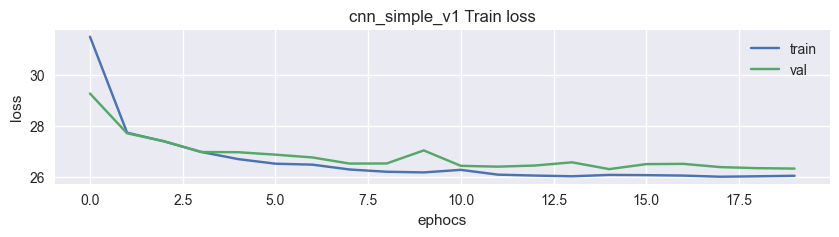

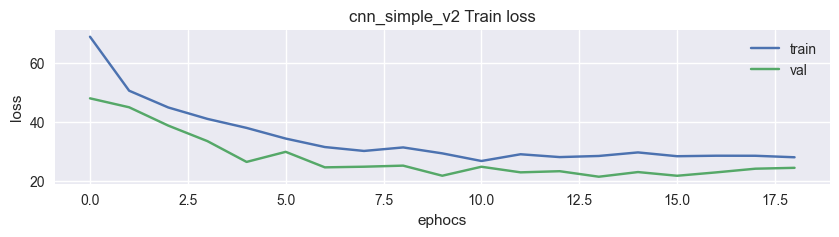

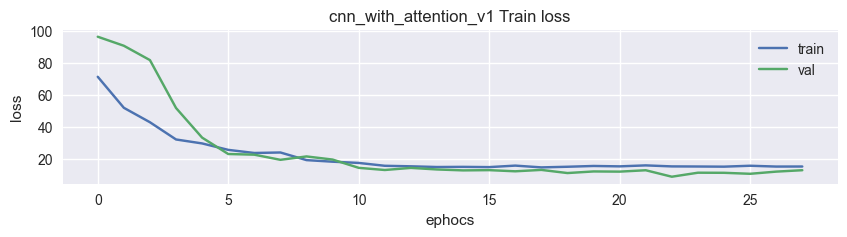

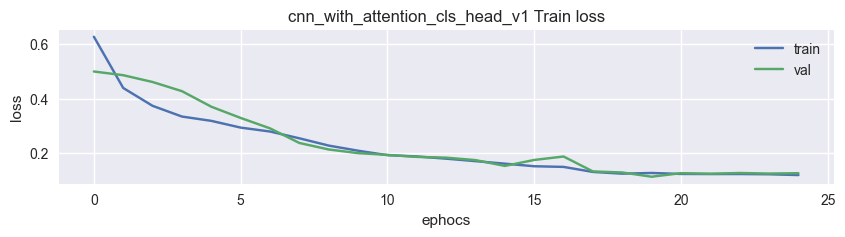

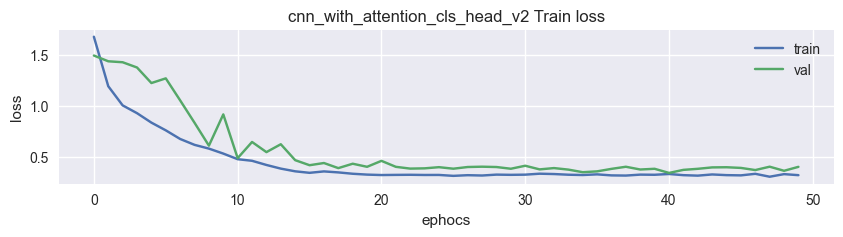

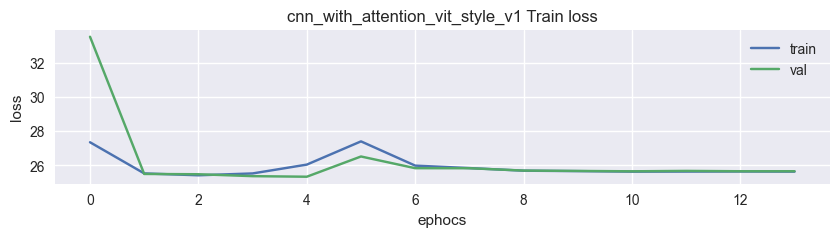

In [82]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))
    plt.grid(True)
    plt.title(f"{model.name} Train loss")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['loss'], label='train')
    plt.plot(model.history['val_loss'], label='val')
    plt.legend()
    plt.show()

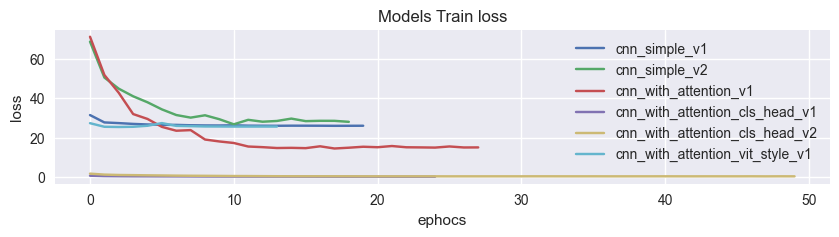

In [83]:
plt.figure(figsize=(10,2))
plt.title(f"Models Train loss")
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('ephocs')

for i, model in enumerate(models_list):
    plt.plot(model.history['loss'], label=model.name)

plt.legend()
plt.show()

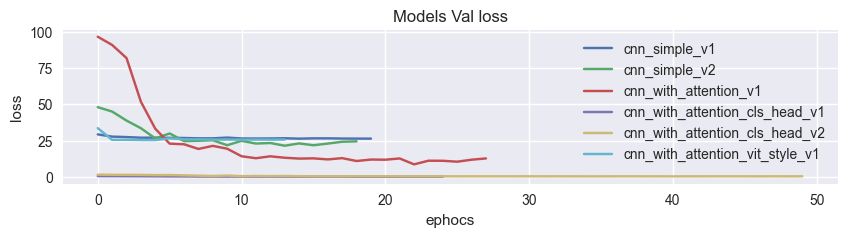

In [84]:
plt.figure(figsize=(10,2))
plt.title(f"Models Val loss")
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('ephocs')

for i, model in enumerate(models_list):
    plt.plot(model.history['val_loss'], label=model.name)

plt.legend()
plt.show()

# Model Eval

silhouette score

In [86]:
eval_df = []

for model in models_list:
    # Extract embeddings
    train_embedding = model.feature_extractor_model.predict(X_train)
    test_embedding = model.feature_extractor_model.predict(X_test)

    # --- Silhouette score ---
    score = silhouette_score(test_embedding, y_test, metric="euclidean")

    # --- k-NN classification ---
    knn = KNeighborsClassifier(n_neighbors=3, metric="euclidean")

    knn.fit(train_embedding, y_train)
    y_pred = knn.predict(test_embedding)
    acc = accuracy_score(y_test, y_pred)

    print(f"Model Name: {model.name}, Silhouette score: {score:.4f}, 3-NN Accuracy: {acc:.4f}")

    eval_df.append({
        "Model Name": model.name,
        "Train Type": model.train_type,
        "Silhouette Score": score,
        "3-NN Accuracy": acc
    })

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Model Name: cnn_simple_v1, Silhouette score: 0.0991, 3-NN Accuracy: 0.9614
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
Model Name: cnn_simple_v2, Silhouette score: 0.1554, 3-NN Accuracy: 0.9779
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Model Name: cnn_with_attention_v1, Silhouette score: 0.0534, 3-NN Accuracy: 0.7484
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Model Name: cnn_with_attention_cls_head_v1, Silhouette score: -0.0825, 3-NN Accuracy: 0.3355
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Model Name: cnn_with_attention_cls_head_v2, Silhouette score: -0.1211, 3-NN Accuracy: 0.3704
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
Model Name: cnn_with_attention_vit_style_v1, Silhouette score: -0.0521,

In [87]:
eval_df = pd.DataFrame(eval_df)
eval_df = eval_df.sort_values(by="Silhouette Score", ascending=False).reset_index()
eval_df.to_csv(os.path.join(BASE_DIR, 'model_evaluation.csv'), index=False)

# Model Explanation

In [88]:
def explain_visualize_intermediate_features(model, single_input_image):

    # Add batch dimension
    input_data = np.expand_dims(single_input_image, axis=0)

    # Collect Conv2D outputs
    outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    output_names = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

    # ✅ Ensure model is built (Sequential or Functional)
    try:
        model_input = model.input
    except (ValueError, AttributeError):
        # Force build by calling with dummy input
        _ = model(np.zeros((1, *single_input_image.shape)))
        model_input = model.input

    # ✅ Build intermediate model correctly
    intermediate_model = Model(inputs=model_input, outputs=outputs)

    # Run prediction safely
    try:
        intermediate_outputs = intermediate_model.predict(input_data)
    except KeyError:
        # Sometimes Functional graph mismatch happens, rebuild with explicit call
        _ = model(input_data)  # build properly with the real input
        intermediate_model = Model(inputs=model.input, outputs=outputs)
        intermediate_outputs = intermediate_model.predict(input_data)

    # Return dictionary for further processing
    return {name: output for name, output in zip(output_names, intermediate_outputs)}


In [89]:
def explain_intermediate_kernel(model, layer_name, filter_index=0):
    filter_index = int(filter_index)

    # Create a submodel that outputs the target layer
    submodel = tf.keras.Model(inputs=model.inputs,
                              outputs=model.get_layer(layer_name).output)

    # Start from random noise image
    input_img_data = tf.random.uniform((1, *IMG_SHAPE))

    # Optimization loop
    step = 1.0
    for i in range(30):
        with tf.GradientTape() as tape:
            tape.watch(input_img_data)
            activation = submodel(input_img_data)
            loss = tf.reduce_mean(activation[..., filter_index])
        grads = tape.gradient(loss, input_img_data)
        grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_img_data = input_img_data + grads * step

    # Convert to displayable image
    img = input_img_data[0].numpy()
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 64
    img += 128
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [90]:
def explain_models(single_input, explain_name, margin = 25, cols = 16, resize_factor=15):
    img_input_resized = cv2.resize(single_input.squeeze(), (IMG_W * 10, IMG_H * 10))
    img_input_resized = (img_input_resized - img_input_resized.min()) / (img_input_resized.max() - img_input_resized.min() + 1e-5) * 255.0
    img_input_resized = img_input_resized.astype(np.uint8)

    os.makedirs(os.path.join(BASE_DIR, 'models_explain', str(explain_name)), exist_ok=True)
    colored = cv2.applyColorMap(img_input_resized, cv2.COLORMAP_VIRIDIS)
    cv2.imwrite(os.path.join(BASE_DIR, 'models_explain', str(explain_name), 'input_image.png'), colored)

    for model in models_list[2:]:
        explain_model_path = os.path.join(BASE_DIR, 'models_explain', str(explain_name), model.name)
        os.makedirs(explain_model_path, exist_ok=True)

        # kernels Output
        output_dict = explain_visualize_intermediate_features(model.feature_extractor_model, single_input)

        counter_k = 0
        for k, v in output_dict.items():
            explain_kernel_path =  os.path.join(explain_model_path, f'kernel no {counter_k} Output.png' )

            filters_i = v.shape[-1]
            cols_i = cols
            rows_i = math.ceil(filters_i / cols_i)

            img_i = np.zeros((rows_i * IMG_H * resize_factor + (rows_i - 1) * margin, cols_i * IMG_W * resize_factor + (cols_i - 1) * margin), dtype=np.uint8)

            features_images = np.split(v, v.shape[-1], axis=-1)

            for j, img_j in enumerate(features_images):
                row_j = j // cols_i
                col_j = j % cols_i

                img_j = cv2.resize(img_j[0, :, :], (IMG_W * resize_factor, IMG_H * resize_factor))
                img_j = (img_j - img_j.min()) / (img_j.max() - img_j.min() + 1e-5) * 255.0
                img_j = img_j.astype(np.uint8)

                start_y = row_j * (IMG_H * resize_factor + margin)
                start_x = col_j * (IMG_W * resize_factor + margin)

                img_i[start_y:start_y + IMG_H * resize_factor, start_x:start_x + IMG_W * resize_factor] = img_j

            colored = cv2.applyColorMap(img_i, cv2.COLORMAP_VIRIDIS)
            cv2.imwrite(explain_kernel_path, colored)

            counter_k += 1


    # Intermediate kernels Weights
    for model in models_list:
        explain_kernels_path =  os.path.join(BASE_DIR, 'models_explain', "Intermediate Kernels",f"{model.name}")

        if os.path.exists(explain_kernels_path) == True:
            continue

        os.makedirs(explain_kernels_path, exist_ok=True)

        counter = 0

        for i, layer in enumerate(model.feature_extractor_model.layers):
            if counter > 0 :
                break

            if isinstance(layer, Conv2D):
                counter += 1
                explain_kernel_path =  os.path.join(explain_kernels_path, f'layer no {i} kernel weights.png' )

                filters, biases = layer.get_weights()
                n_filters = filters.shape[-1]

                cols_i = cols
                rows_i = math.ceil(n_filters / cols_i)

                img_i = np.zeros((rows_i * IMG_H * resize_factor + (rows_i - 1) * margin, cols_i * IMG_W * resize_factor + (cols_i - 1) * margin), dtype=np.uint8)


                for fitler_j in range(n_filters):
                    img_j = explain_intermediate_kernel(model.feature_extractor_model, layer.name, filter_index=fitler_j)

                    row_j = fitler_j // cols_i
                    col_j = fitler_j % cols_i

                    img_j = cv2.resize(img_j, (IMG_W * resize_factor, IMG_H * resize_factor))
                    img_j = (img_j - img_j.min()) / (img_j.max() - img_j.min() + 1e-5) * 255.0
                    img_j = img_j.astype(np.uint8)

                    start_y = row_j * (IMG_H * resize_factor + margin)
                    start_x = col_j * (IMG_W * resize_factor + margin)

                    img_i[start_y:start_y + IMG_H * resize_factor, start_x:start_x + IMG_W * resize_factor] = img_j

                colored = cv2.applyColorMap(img_i, cv2.COLORMAP_VIRIDIS)
                cv2.imwrite(explain_kernel_path, colored)

In [91]:
for i in range(3):
    explain_models(random.choice(X_train), f'Trial {i+1}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


# Latent Space

In [92]:
def get_plot_latent_space(feature_extractor, input_data, labels, save_path, model_name):
    # Extract features
    features = feature_extractor.predict(input_data)

    # Run UMAP
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    features_2d = reducer.fit_transform(features)
    print(f"{features_2d.shape = }")

    # Plot
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                          c=labels, alpha=0.7, cmap='tab10')

    # Legend with human-readable labels
    handles, _ = scatter.legend_elements()
    class_labels = [fashion_mnist_labels[i] for i in sorted(set(labels))]
    plt.legend(handles, class_labels, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f'UMAP Visualization of Latent Space {model_name}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


features_2d.shape = (1000, 2)


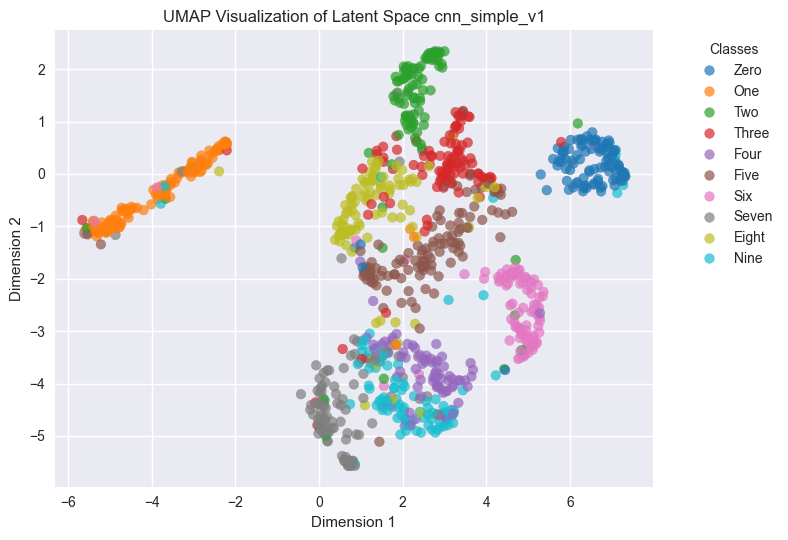

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


features_2d.shape = (1000, 2)


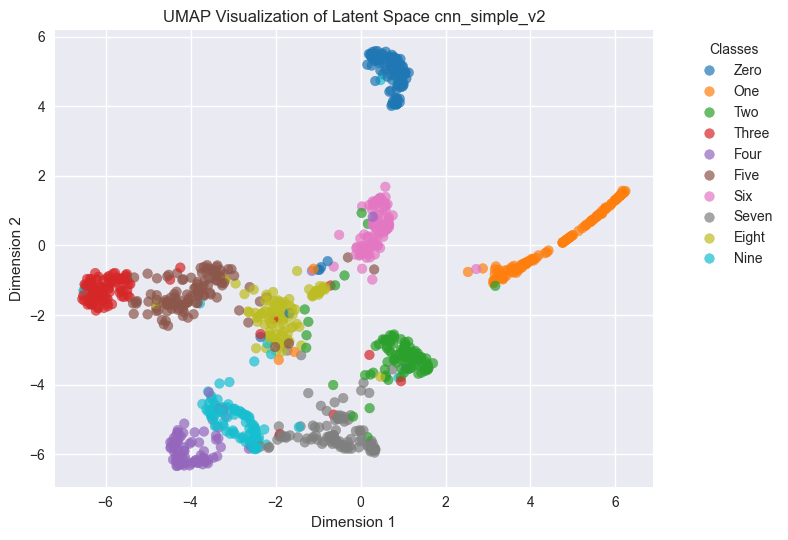

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


features_2d.shape = (1000, 2)


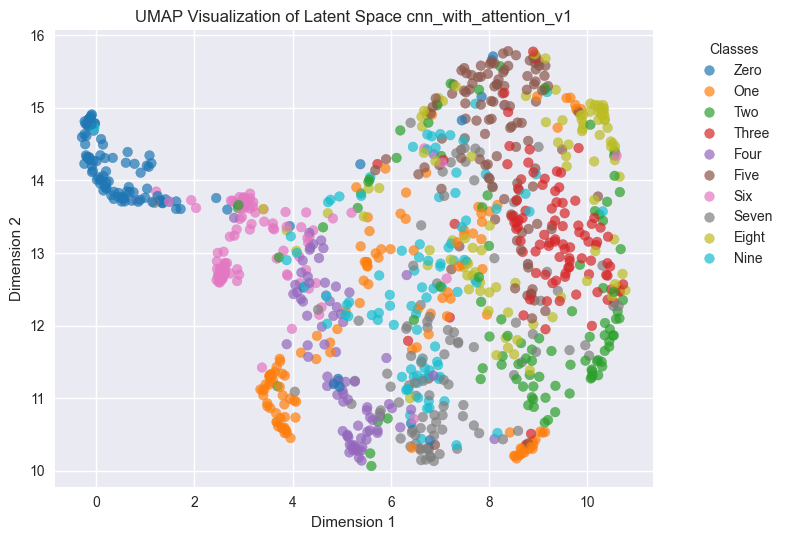

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


features_2d.shape = (1000, 2)


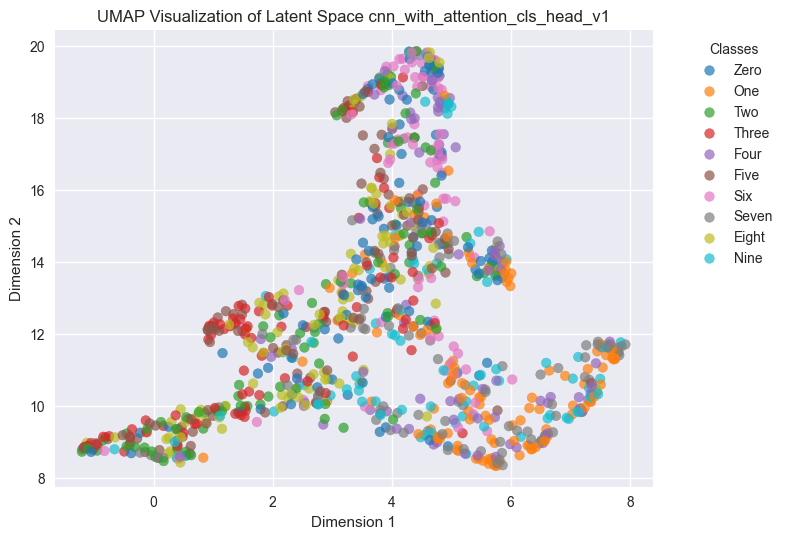

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


features_2d.shape = (1000, 2)


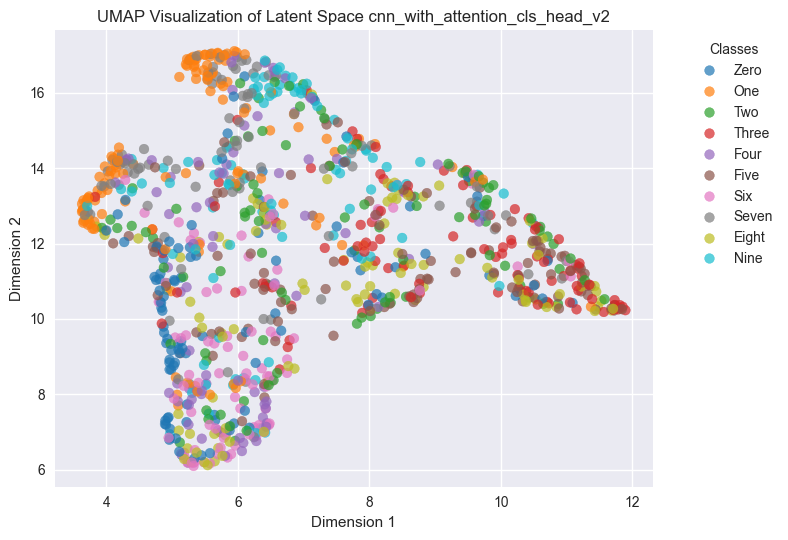

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


features_2d.shape = (1000, 2)


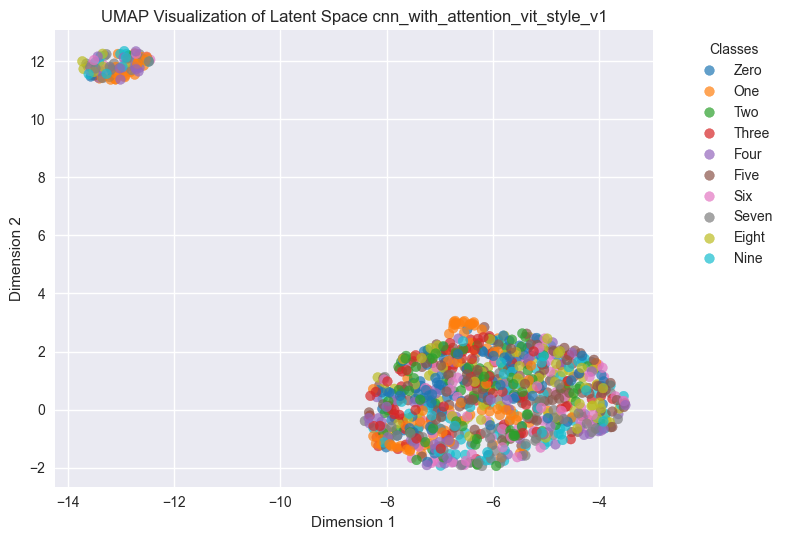

In [93]:
for model in models_list:
    m = model.feature_extractor_model

    dir_save = os.path.join(BASE_DIR, 'latent_space')
    os.makedirs(dir_save, exist_ok=True)
    save_path = os.path.join(dir_save, f'{model.name} latent space.png')

    get_plot_latent_space(m, X_test[:1_000], y_test[:1_000], save_path, model.name)
